In [ ]:
from __future__ import print_function
import argparse
import os
import random
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt


In [ ]:
# Set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results


cudnn.benchmark = True

# Batch size during training
batch_size = 32

# Spatial size of training images
image_size = 100

# Number of channels in the training images
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 32

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = int(ngf)

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [ ]:
! curl https://cernbox.cern.ch/s/zZDKjltAcJW0RB7/download -o Data-ML-Jet-Project.tar.gz
! tar -xvzf Data-ML-Jet-Project.tar.gz
! ls Data-MLtutorial/JetDataset/
! rm Data-ML-Jet-Project.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  13.1M      0 --:--:--  0:00:25 --:--:-- 16.7M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# input, convert to float32 with proper shape in numpy and then to torch tensor
file_set = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
images_numpy = np.concatenate([np.array(h5py.File(f).get('jetImage')) for f in file_set]).reshape(-1, nc, image_size, image_size)
float_images = images_numpy.astype('float32')
print(float_images.shape)

dataset = torch.from_numpy(float_images)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


(50000, 1, 100, 100)


In [ ]:
# tested for cropping all images, found non zero pixels at the edge -> did not crop
#testa = []
#for i in images_numpy:
#    image = i[0]
#    for j in range(100):
#        for k in range(100):
#            if image[j,k]==0 and image[99-j,99-k]==0:
#                continue
#            else:
#                testa.append(min(j,k,100-j,100-k))
#                break
#print(min(testa))

(100, 100)


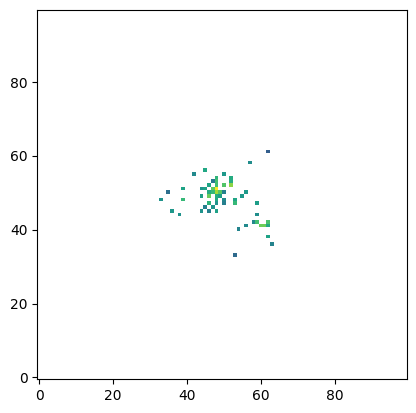

In [ ]:
# Example image

from matplotlib.colors import LogNorm

f = h5py.File('Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5')
image_eg = np.array(f.get('jetImage'))[0]

print(image_eg.shape)
plt.imshow(image_eg, origin='lower',norm=LogNorm(vmin=0.01))
plt.show()

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 16, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.LeakyReLU(True),
            # state size. (ngf*16) x 3 x 3
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(True),
            # state size. (ngf*8) x 6 x 6
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(True),
            # state size. (ngf*4) x 12 x 12
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(True),
            # state size. (ngf*2) x 25 x 25
            nn.ConvTranspose2d( ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(True),
            # state size. (ngf) x 50 x 50
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 100 x 100
        )

    def forward(self, input):
        output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)


print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(32, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 100 x 100
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 50 x 50
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 25 x 25
            nn.Conv2d(ndf * 2, ndf * 4, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 12 x 12
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 6 x 6
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 3 x 3
            nn.Conv2d(ndf * 16, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)


print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr= lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr= lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.shape[0]
        # Generate noisy labels for discriminator training
        real_label_alpha = real_label - np.abs(np.random.randn()/10)
        label = torch.full((b_size,), real_label_alpha, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/1563]	Loss_D: 2.3185	Loss_G: 7.1802	D(x): 0.3442	D(G(z)): 0.5940 / 0.0098
[0/10][50/1563]	Loss_D: 0.3021	Loss_G: 4.1861	D(x): 0.7836	D(G(z)): 0.0020 / 0.0985
[0/10][100/1563]	Loss_D: 0.1344	Loss_G: 8.4079	D(x): 0.9047	D(G(z)): 0.0008 / 0.0020
[0/10][150/1563]	Loss_D: 0.0923	Loss_G: 24.2988	D(x): 0.9758	D(G(z)): 0.0013 / 0.0006
[0/10][200/1563]	Loss_D: 0.5321	Loss_G: 9.0505	D(x): 0.9772	D(G(z)): 0.0017 / 0.0009
[0/10][250/1563]	Loss_D: 0.2576	Loss_G: 9.3266	D(x): 0.9019	D(G(z)): 0.0009 / 0.0008
[0/10][300/1563]	Loss_D: 0.4708	Loss_G: 33.1075	D(x): 0.8946	D(G(z)): 0.0003 / 0.0002
[0/10][350/1563]	Loss_D: 0.4219	Loss_G: 22.3952	D(x): 0.9846	D(G(z)): 0.0068 / 0.0097
[0/10][400/1563]	Loss_D: 0.1570	Loss_G: 15.4071	D(x): 0.9065	D(G(z)): 0.0002 / 0.0004
[0/10][450/1563]	Loss_D: 0.6365	Loss_G: 16.0472	D(x): 0.9206	D(G(z)): 0.0003 / 0.0001
[0/10][500/1563]	Loss_D: 0.0493	Loss_G: 5.7870	D(x): 0.9606	D(G(z)): 0.0047 / 0.0054
[0/10][550/1563]	Loss_D: 0.2507	Loss_

KeyboardInterrupt: ignored

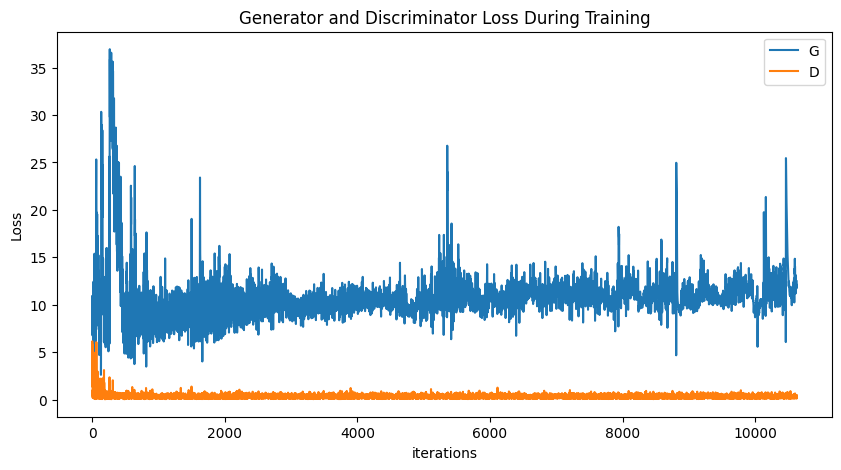

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]